In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

### Implement the SMA(20) strategy with Bitcoin 

~~Try to create the `btc` data frame in one code cell with one assignment (i.e., one `=`).~~
***Write a function `sma()` that accepts a data frame `df` and window size `n`.
Use your `sma()` function to implement the SMA(20) strategy and assign it to data frame `btc_sma`.***

In [3]:
import yfinance as yf

In [4]:
btc = (
    yf.download(tickers='BTC-USD', progress=False)
    .assign(
        Date = lambda x: x.index.tz_localize(None),
    )
    .set_index('Date')
    .rename_axis(columns='Variable')
)

btc.head()

Variable,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.8640,468.1740,452.4220,457.3340,457.3340,21056800
2014-09-18,456.8600,456.8600,413.1040,424.4400,424.4400,34483200
2014-09-19,424.1030,427.8350,384.5320,394.7960,394.7960,37919700
2014-09-20,394.6730,423.2960,389.8830,408.9040,408.9040,36863600
2014-09-21,408.0850,412.4260,393.1810,398.8210,398.8210,26580100


In [5]:
def sma(df, n=20):
    return (
        df
        .assign(
            Return = lambda x: x['Adj Close'].pct_change(),
            SMA = lambda x: x['Adj Close'].rolling(n).mean(),
            Position = lambda x: np.select(
                condlist=[
                    x['Adj Close'].shift() > x['SMA'].shift(), 
                    x['Adj Close'].shift() <= x['SMA'].shift()
                ],
                choicelist=[
                    1, 
                    0
                ],
                default=np.nan
            ),
            Strategy = lambda x: x['Position'] * x['Return']
        )
    )


In [6]:
btc_sma = btc.pipe(sma, n=20)

btc_sma.tail()

Variable,Open,High,Low,Close,Adj Close,Volume,Return,SMA,Position,Strategy
Date,,,,,,,,,,
2023-12-03,39472.2070,40135.6055,39298.1641,39978.3906,39978.3906,15769696322,0.0127,37497.5408,1.0000,0.0127
2023-12-04,39978.6289,42371.7500,39978.6289,41980.0977,41980.0977,39856129827,0.0501,37819.6637,1.0000,0.0501
2023-12-05,41986.2656,44408.6641,41421.1484,44080.6484,44080.6484,36312154535,0.0500,38129.6670,1.0000,0.0500
2023-12-06,44080.0234,44265.7695,43478.0820,43746.4453,43746.4453,29909761586,-0.0076,38509.2508,1.0000,-0.0076
2023-12-07,43769.1328,44042.5898,43019.2070,43213.7109,43213.7109,27723128832,-0.0122,38840.1021,1.0000,-0.0122


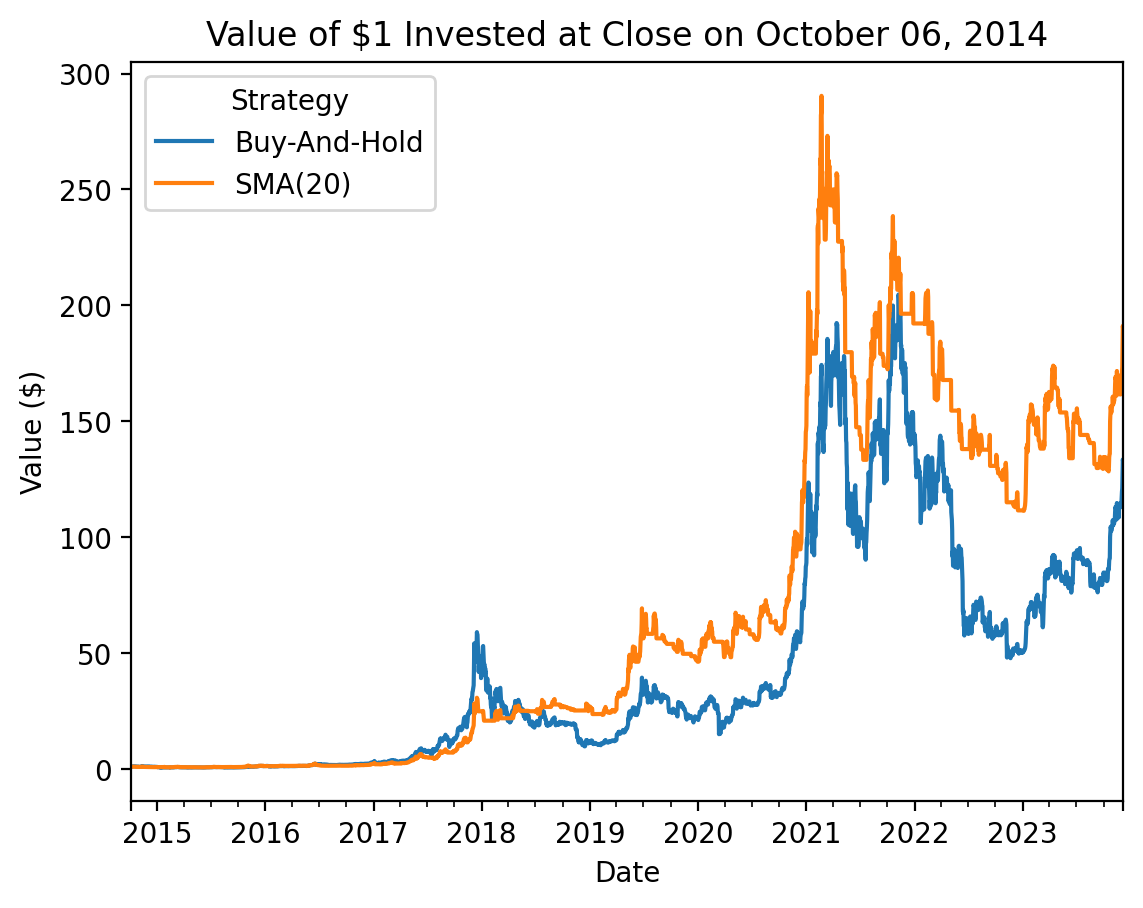

In [7]:
_ = btc_sma[['Return', 'Strategy']].dropna()

(
    _
    .add(1)
    .cumprod()
    .rename_axis(columns='Strategy')
    .rename(columns={'Return': 'Buy-And-Hold', 'Strategy': 'SMA(20)'})
    .plot()
)
plt.ylabel('Value ($)')
plt.title(f'Value of $1 Invested at Close on {_.index[0] - pd.offsets.Day(1):%B %d, %Y}')
plt.show()

### How does SMA(20) outperform buy-and-hold with this sample?

Consider the following:

1. Does SMA(20) avoid the worst performing days? How many of the worst 20 days does SMA(20) avoid? Try the `.sort_values()` or `.nlargest()` method.
1. Does SMA(20) preferentially avoid low-return days? Try to combine the `.groupby()` method and `pd.qcut()` function.
1. Does SMA(20) preferentially avoid high-volatility days? Try to combine the `.groupby()` method and `pd.qcut()` function.

By chance, the SMA(20) strategy avoids all but three of the worst days.

In [8]:
btc_sma.sort_values('Return')[['Position']].head(20).value_counts()

Position
0.0000      17
1.0000       3
dtype: int64

However, SMA(20) does not avoid the best days, again by chance.

In [9]:
btc_sma.sort_values('Return', ascending=False)[['Position']].head(20).value_counts()

Position
0.0000      10
1.0000      10
dtype: int64

In [10]:
btc_sma.groupby('Position')[['Return', 'Strategy']].agg(['mean', 'std'])

Variable Return        Strategy       
           mean    std     mean    std
Position                              
0.0000   0.0006 0.0403   0.0000 0.0000
1.0000   0.0034 0.0341   0.0034 0.0341

The SMA(20) strategy has a slight edge in picking high-return days, again by chance.

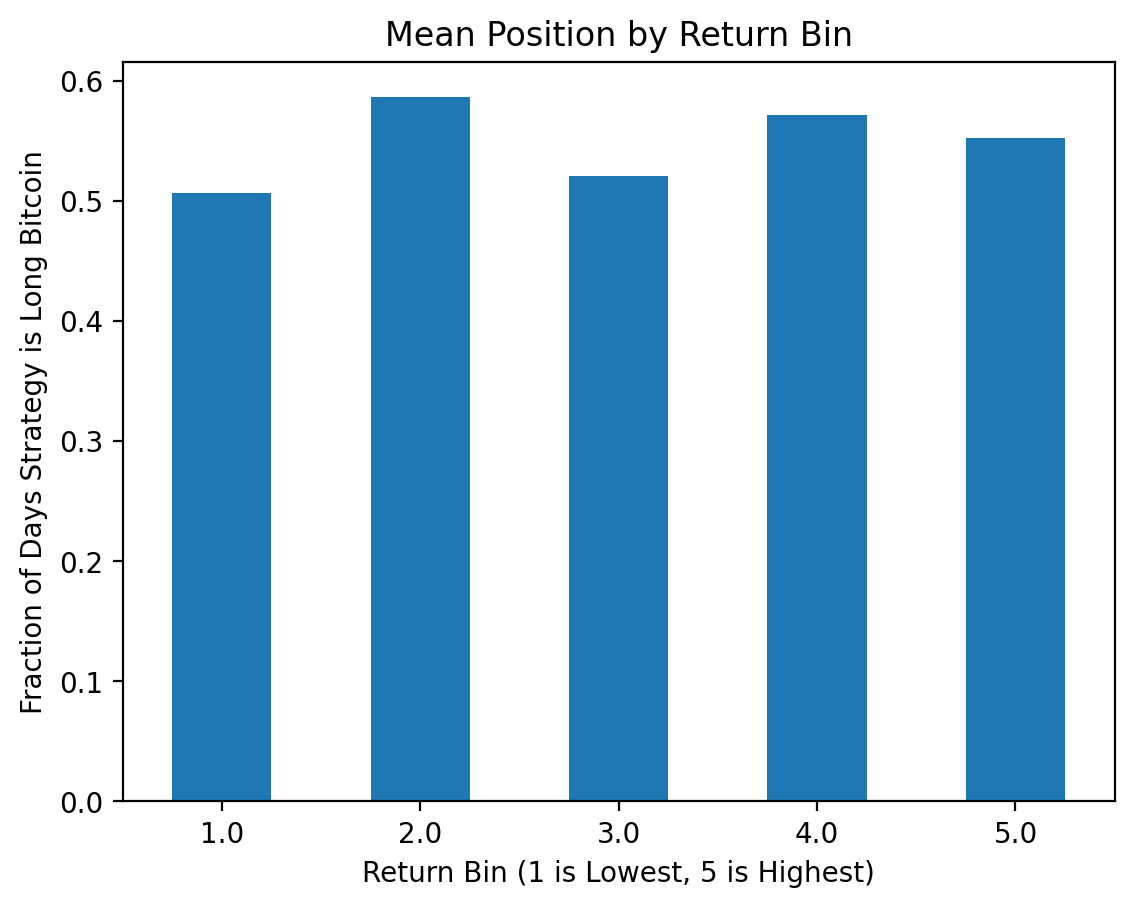

In [11]:
(
    btc_sma
    .assign(q5_return = lambda x: 1 + pd.qcut(x['Return'], q=5, labels=False))
    .groupby('q5_return')
    ['Position']
    .mean()
    .plot(kind='bar')
)

plt.xticks(rotation=0)
plt.xlabel('Return Bin (1 is Lowest, 5 is Highest)')
plt.ylabel('Fraction of Days Strategy is Long Bitcoin')
plt.title('Mean Position by Return Bin')
plt.show()

However, the SMA(20) *does* avoid the high volatility days that create [volatility drag](https://www.kitces.com/blog/volatility-drag-variance-drain-mean-arithmetic-vs-geometric-average-investment-returns/).

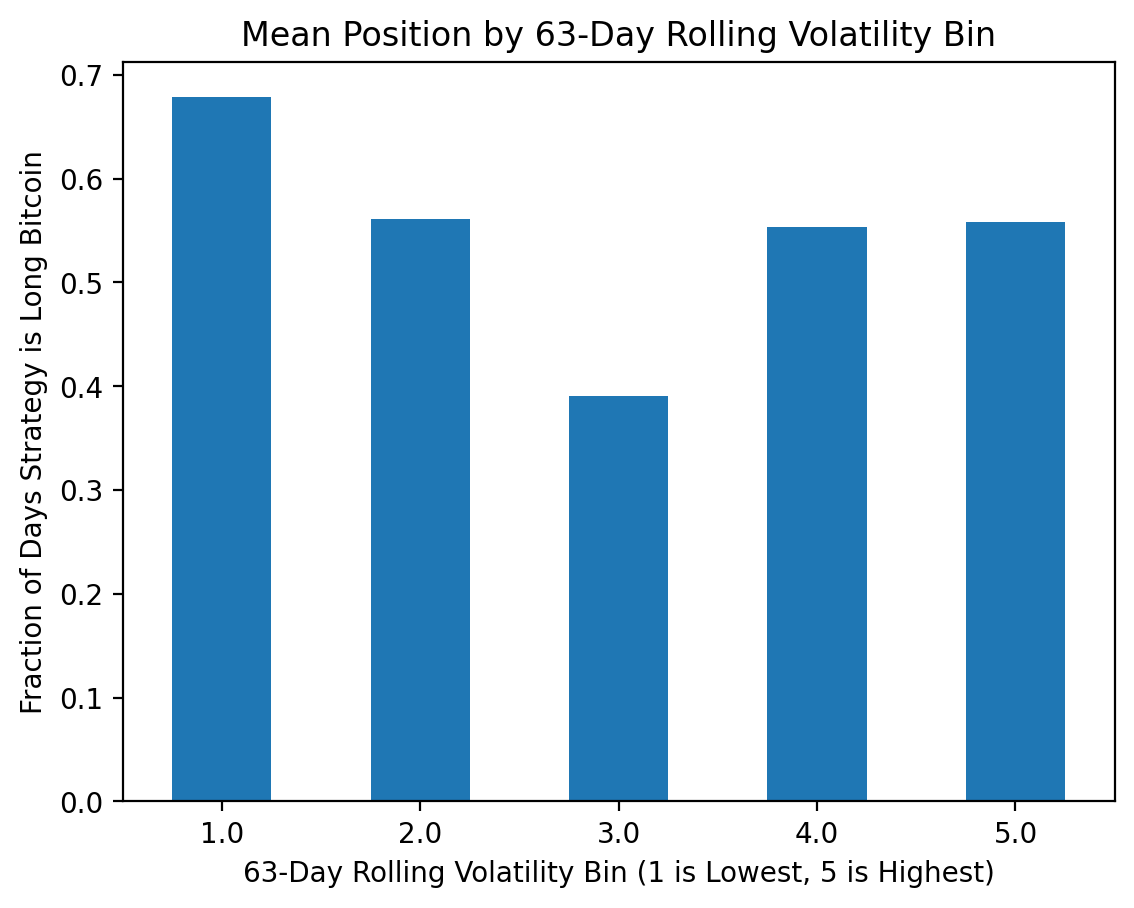

In [12]:
(
    btc_sma
    .assign(
        Volatility = lambda x: x['Return'].rolling(63).std(),
        q5_volatility = lambda x: 1 + pd.qcut(x['Volatility'], q=5, labels=False)
    )
    .groupby('q5_volatility')
    ['Position']
    .mean()
    .plot(kind='bar')
)

plt.xticks(rotation=0)
plt.xlabel('63-Day Rolling Volatility Bin (1 is Lowest, 5 is Highest)')
plt.ylabel('Fraction of Days Strategy is Long Bitcoin')
plt.title('Mean Position by 63-Day Rolling Volatility Bin')
plt.show()

Recall that $Arith\ Mean \approx Geom\ Mean + \frac{\sigma^2}{2}$, so avoiding high volatility (high variance) days, reduced the drag on the  cumulative returns that intermediate-term and long-term investors care about!

In [13]:
(
    btc_sma
    .groupby('Position')
    ['Return']
    .agg(['std', 'mean', lambda x: (1 + x).prod()**(1 / x.count()) - 1])
    .mul(100)
    .rename(columns={'std': 'Volatility', 'mean': 'Arith Mean', '<lambda_0>': 'Geom Mean'})
)

,Volatility,Arith Mean,Geom Mean
Position,,,
0.0000,4.0269,0.0596,-0.0237
1.0000,3.4068,0.3432,0.2859


### Implement the SMA(20) strategy with the market factor from French

We need to impute a market price before we calculate SMA(20).

In [14]:
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

In [15]:
ff = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900',
        session=session
    )
    [0]
    .div(100)
    .assign(
        Mkt = lambda x: x['Mkt-RF'] + x['RF'],
        Price = lambda x: x['Mkt'].add(1).cumprod()
    )
)

In [16]:
ff_sma = (
    ff
    .rename(columns={'Price': 'Adj Close'})
    .pipe(sma, n=20)
)

ff_sma.tail()

,Mkt-RF,SMB,HML,RF,Mkt,Adj Close,Return,SMA,Position,Strategy
Date,,,,,,,,,,
2023-10-25,-0.0158,-0.0030,0.0084,0.0002,-0.0156,10168.8352,-0.0156,10463.6550,0.0000,-0.0000
2023-10-26,-0.0115,0.0085,0.0166,0.0002,-0.0113,10054.0290,-0.0113,10441.2382,0.0000,-0.0000
2023-10-27,-0.0053,-0.0035,-0.0057,0.0002,-0.0051,10002.8540,-0.0051,10417.5702,0.0000,-0.0000
2023-10-30,0.0115,-0.0039,0.0028,0.0002,0.0117,10119.9874,0.0117,10400.3821,0.0000,0.0000
2023-10-31,0.0063,0.0005,-0.0008,0.0002,0.0065,10185.8686,0.0065,10394.2261,0.0000,0.0000


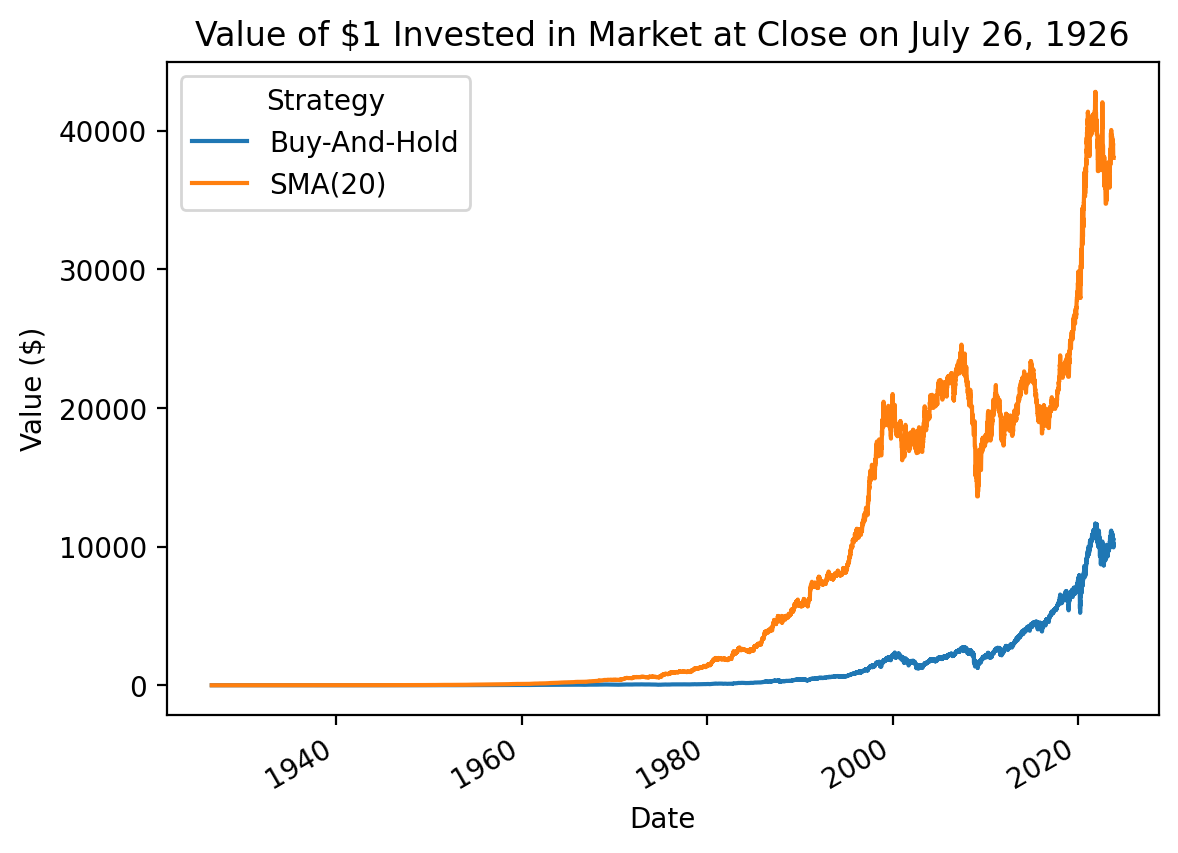

In [17]:
_ = ff_sma[['Return', 'Strategy']].dropna()

(
    _
    .add(1)
    .cumprod()
    .rename_axis(columns='Strategy')
    .rename(columns={'Return': 'Buy-And-Hold', 'Strategy': 'SMA(20)'})
    .plot()
)
plt.ylabel('Value ($)')
plt.title(f'Value of $1 Invested in Market at Close on {_.index[0] - pd.offsets.Day(1):%B %d, %Y}')
plt.show()

### How often does SMA(20) outperform buy-and-hold with 10-year rolling windows?

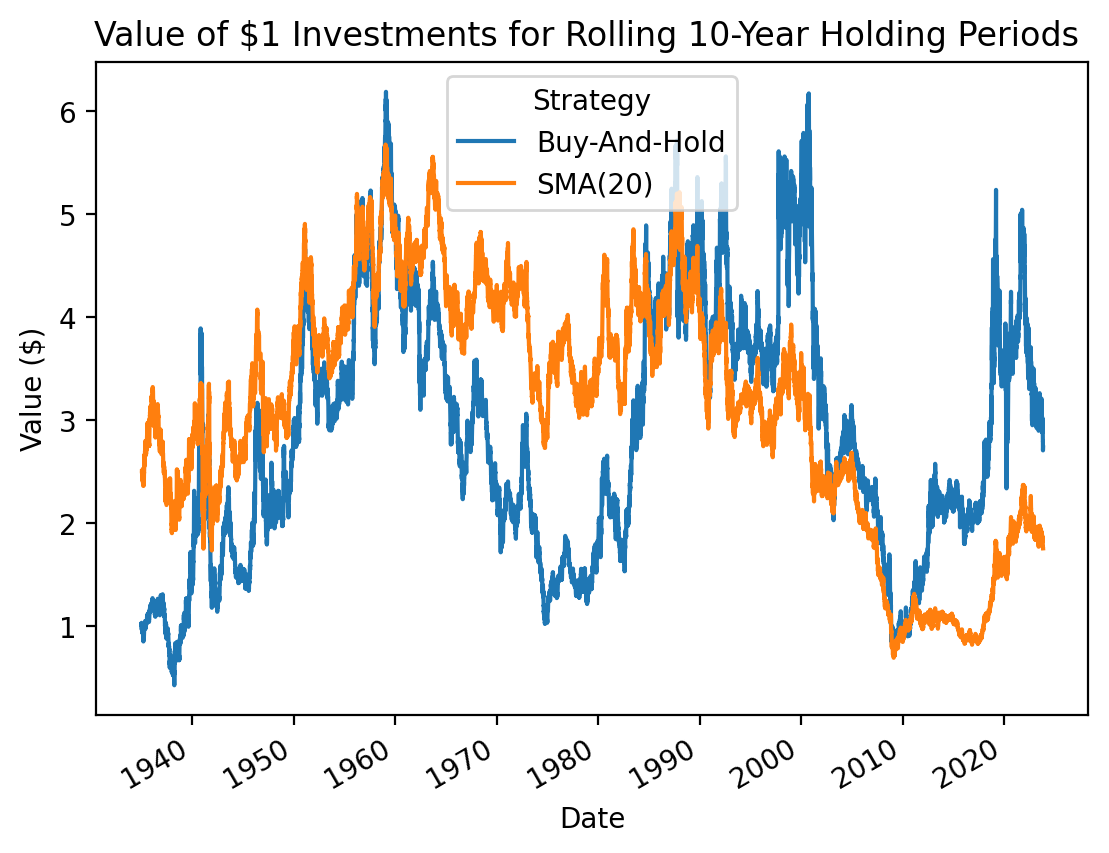

In [18]:
(
    ff_sma
    [['Return', 'Strategy']]
    .rolling(10 * 252)
    .apply(lambda x: (1 + x).prod())
    .rename_axis(columns='Strategy')
    .rename(columns={'Return': 'Buy-And-Hold', 'Strategy': 'SMA(20)'})
    .plot()
)
plt.ylabel('Value ($)')
plt.title(f'Value of $1 Investments for Rolling 10-Year Holding Periods ')
plt.show()

In the previous example, SMA(20) looks amazing!
But over many shorter holding periods, we see the two are comparable.
This is largely because the SMA(20) strategy *by pure chance* avoids big market draw downs!

In [19]:
ff_sma.sort_values('Return')[['Position', 'Return', 'Strategy']].head(10)

,Position,Return,Strategy
Date,,,
1987-10-19,0.0000,-0.1741,-0.0000
2020-03-16,0.0000,-0.1199,-0.0000
1929-10-29,0.0000,-0.1199,-0.0000
1929-10-28,0.0000,-0.1127,-0.0000
1929-11-06,0.0000,-0.0973,-0.0000
2020-03-12,0.0000,-0.0962,-0.0000
1933-07-21,0.0000,-0.0921,-0.0000
2008-12-01,1.0000,-0.0895,-0.0895
2008-10-15,0.0000,-0.0878,-0.0000


SMA(20) also avoids the up days.
However, for this sample, missing the extreme down days helps more than missing the extreme updays hurts.

In [20]:
ff_sma.sort_values('Return', ascending=False)[['Position', 'Return', 'Strategy']].head(10)

,Position,Return,Strategy
Date,,,
1933-03-15,0.0000,0.1576,0.0000
1929-10-30,0.0000,0.1218,0.0000
2008-10-13,0.0000,0.1135,0.0000
1931-10-06,0.0000,0.1116,0.0000
1932-09-21,0.0000,0.1096,0.0000
2008-10-28,0.0000,0.0977,0.0000
2020-03-24,0.0000,0.0935,0.0000
2020-03-13,0.0000,0.0897,0.0000
1939-09-05,1.0000,0.0879,0.0879


We can also think about this problem by decade.
If we want to get proper calendar decades (instead of 10-year periods that start in 1926), we combine `.groupby()` with an anonymous function that converts the date-time index to a proper calendar decade.
Again, we see that SMA(20) and buy-and-hold trade wins, but SMA(20) wins bigs in the 1930s!

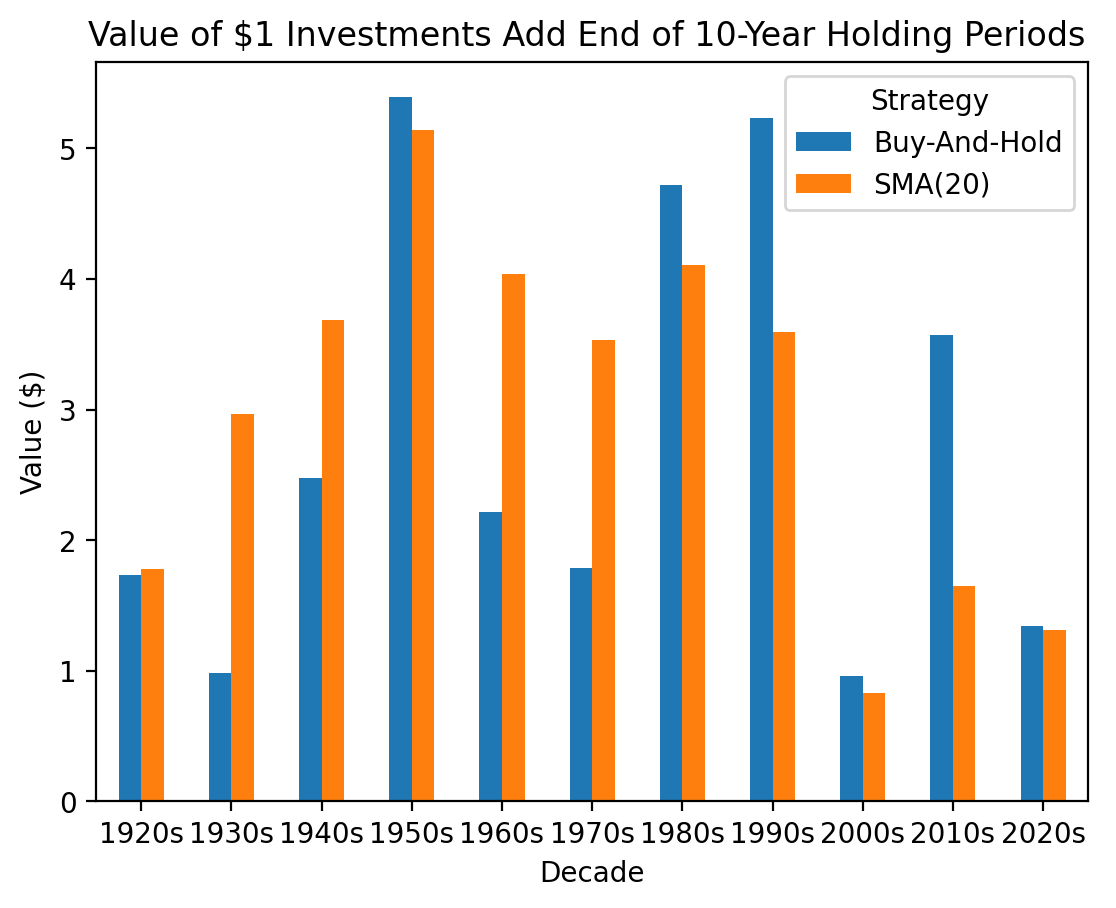

In [21]:
(
    ff_sma
    [['Return', 'Strategy']]
    .groupby(lambda x: f'{(x.year // 10) * 10}s')
    .apply(lambda x: (1 + x).prod())
    .rename_axis(index='Decade', columns='Strategy')
    .rename(columns={'Return': 'Buy-And-Hold', 'Strategy': 'SMA(20)'})
    .plot(kind='bar')
)
plt.xticks(rotation=0)
plt.ylabel('Value ($)')
plt.title(f'Value of $1 Investments Add End of 10-Year Holding Periods ')
plt.show()

In fact, buy-and-hold outperforms SMA(20) is we start in 1950.

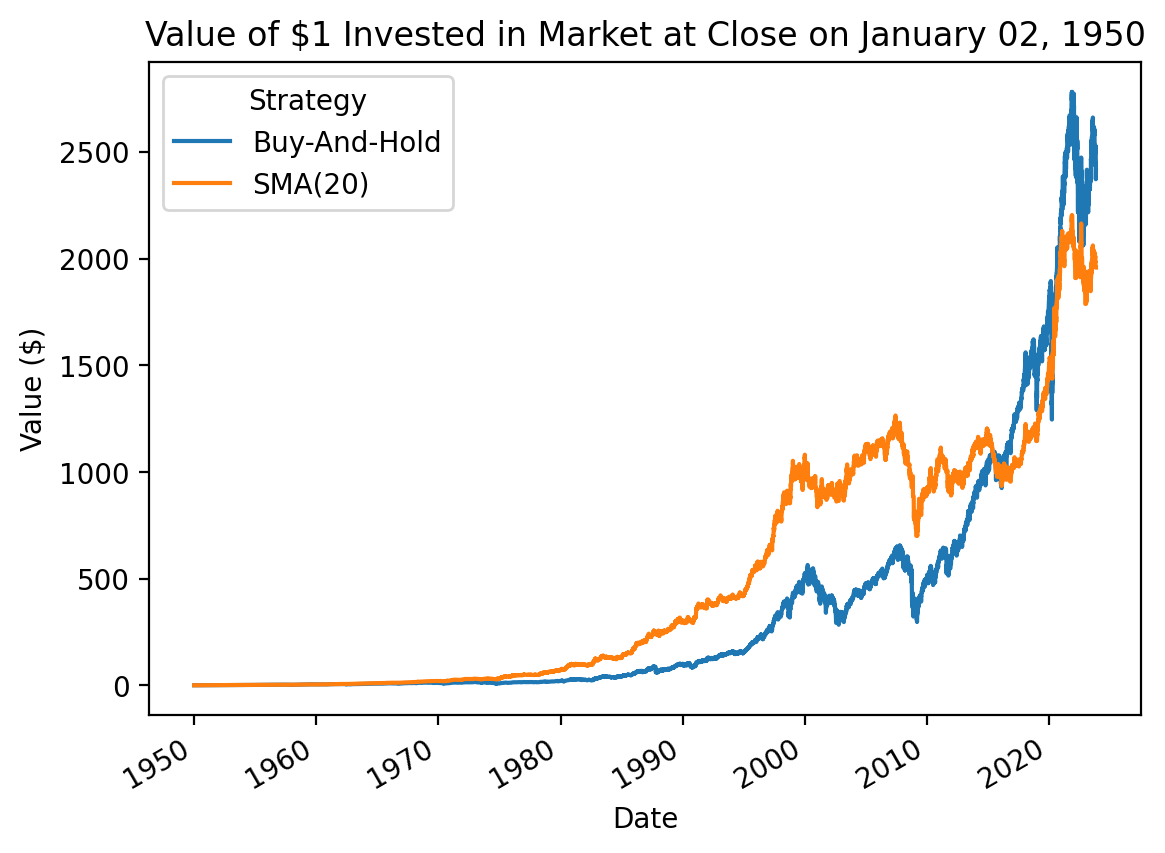

In [22]:
_ = ff_sma.loc['1950':, ['Return', 'Strategy']].dropna()

(
    _
    .add(1)
    .cumprod()
    .rename_axis(columns='Strategy')
    .rename(columns={'Return': 'Buy-And-Hold', 'Strategy': 'SMA(20)'})
    .plot()
)
plt.ylabel('Value ($)')
plt.title(f'Value of $1 Invested in Market at Close on {_.index[0] - pd.offsets.Day(1):%B %d, %Y}')
plt.show()

### Implement a long-only BB(20, 2) strategy with Bitcoin

More on Bollinger Bands [here](https://www.bollingerbands.com/bollinger-bands) and [here](https://www.bollingerbands.com/bollinger-band-rules).
In short, Bollinger Bands are bands around a trend, typically defined in terms of simple moving averages and volatilities.
Here, long-only BB(20, 2) implies we have upper and lower bands at 2 standard deviations above and below SMA(20):

1. Buy when the closing price crosses LB(20) from below, where LB(20) is SMA(20) minus 2 sigma
1. Sell when the closing price crosses UB(20) from above, where UB(20) is SMA(20) plus 2 sigma
1. No short-selling

The long-only BB(20, 2) is more difficult to implement than the long-only SMA(20) because we need to track buys and sells.
For example, if the closing price is between LB(20) and BB(20), we need to know if our last trade was a buy or a sell.
Further, if the closing price is below LB(20), we can still be long because we sell when the closing price crosses UB(20) from above.

***Again, write a function `bb()` that accepts a data frame `df`, window size `n`, and number of standard deviations `m`.
Use your `bb()` function to implement the BB(20, 2) strategy and assign it to data frame `btc_bb`.***

In [23]:
def bb(df, n=20, m=2):
    return (
        df
        .assign(
            Return = lambda x: x['Adj Close'].pct_change(),
            SMA = lambda x: x['Adj Close'].rolling(n).mean(),
            SMV = lambda x: x['Adj Close'].rolling(n).std(),
            UB = lambda x: x['SMA'] + m*x['SMV'],
            LB = lambda x: x['SMA'] - m*x['SMV'],
            Position_with_nan = lambda x: np.select(
                condlist=[
                    (x['Adj Close'].shift(1) > x['LB'].shift(1)) & (x['Adj Close'].shift(2) <= x['LB'].shift(2)), 
                    (x['Adj Close'].shift(1) < x['UB'].shift(1)) & (x['Adj Close'].shift(2) >= x['UB'].shift(2))
                ],
                choicelist=[
                    1, 
                    0
                ],
                default=np.nan
            ),
            Position = lambda x: x['Position_with_nan'].fillna(method='ffill'),
            Strategy = lambda x: x['Position'] * x['Return']
        )
    )


In [24]:
btc_bb = btc.pipe(bb, n=20, m=2)

btc_bb.tail()

Variable,Open,High,Low,Close,Adj Close,Volume,Return,SMA,SMV,UB,LB,Position_with_nan,Position,Strategy
Date,,,,,,,,,,,,,,
2023-12-03,39472.2070,40135.6055,39298.1641,39978.3906,39978.3906,15769696322,0.0127,37497.5408,1083.4865,39664.5139,35330.5678,NaN,0.0000,0.0000
2023-12-04,39978.6289,42371.7500,39978.6289,41980.0977,41980.0977,39856129827,0.0501,37819.6637,1385.6741,40591.0119,35048.3154,NaN,0.0000,0.0000
2023-12-05,41986.2656,44408.6641,41421.1484,44080.6484,44080.6484,36312154535,0.0500,38129.6670,1970.2517,42070.1703,34189.1637,NaN,0.0000,0.0000
2023-12-06,44080.0234,44265.7695,43478.0820,43746.4453,43746.4453,29909761586,-0.0076,38509.2508,2277.1432,43063.5372,33954.9644,NaN,0.0000,-0.0000
2023-12-07,43769.1328,44042.5898,43019.2070,43213.7109,43213.7109,27723128832,-0.0122,38840.1021,2458.1446,43756.3913,33923.8130,NaN,0.0000,-0.0000


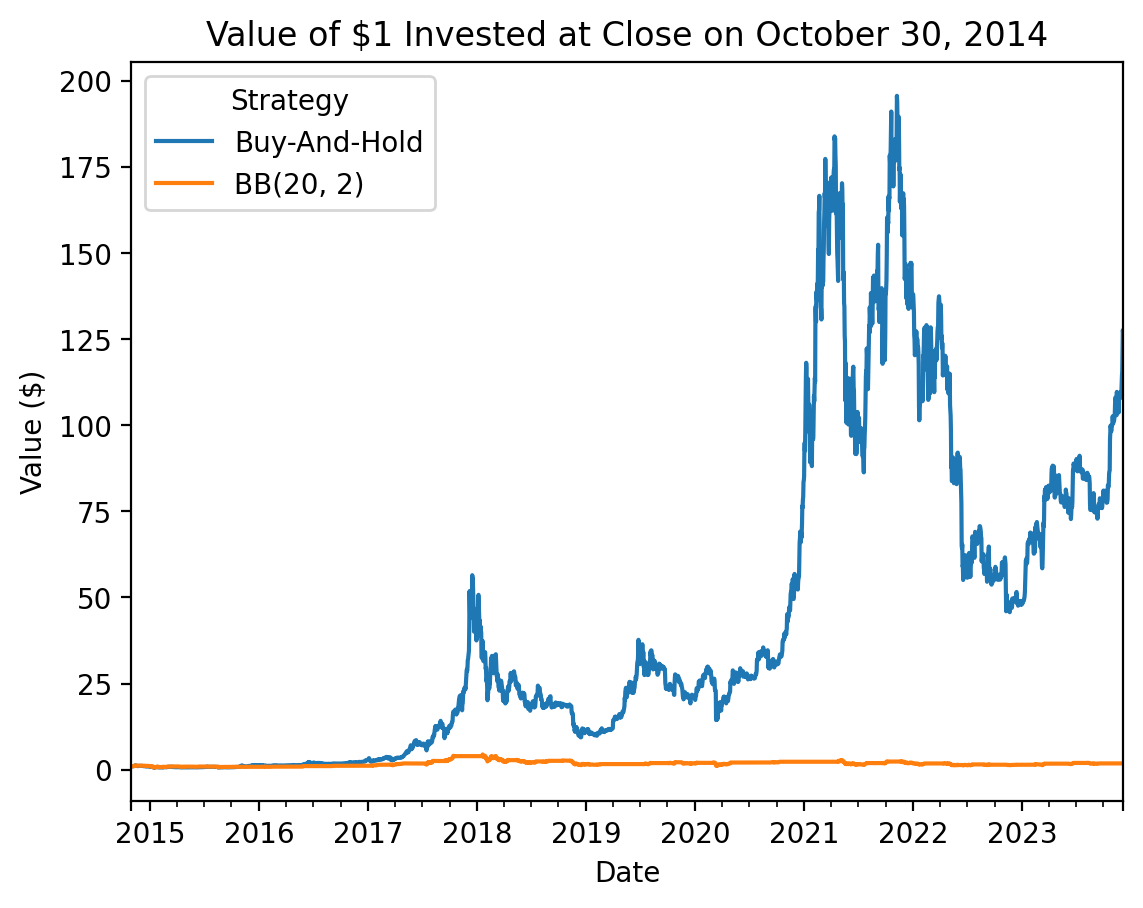

In [25]:
_ = btc_bb[['Return', 'Strategy']].dropna()

(
    _
    .add(1)
    .cumprod()
    .rename_axis(columns='Strategy')
    .rename(columns={'Return': 'Buy-And-Hold', 'Strategy': 'BB(20, 2)'})
    .plot()
)
plt.ylabel('Value ($)')
plt.title(f'Value of $1 Invested at Close on {_.index[0] - pd.offsets.Day(1):%B %d, %Y}')
plt.show()

For an asset that we know has large positive returns over the sample, "time in the market" beats "timing the market".

### Implement a long-short RSI(14) strategy with Bitcoin

From [Fidelity](https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/rsi):

> The Relative Strength Index (RSI), developed by J. Welles Wilder, is a momentum oscillator that measures the speed and change of price movements. The RSI oscillates between zero and 100. Traditionally the RSI is considered overbought when above 70 and oversold when below 30. Signals can be generated by looking for divergences and failure swings. RSI can also be used to identify the general trend.

Here is the RSI formula: $RSI(n) = 100 - \frac{100}{1 + RS(n)}$, where $RS(n) = \frac{SMA(U, n)}{SMA(D, n)}$.
For "up days", $U = \Delta Adj\ Close$ and $D = 0$, and, for "down days", $U = 0$ and $D = - \Delta Adj\ Close$.
Therefore, $U$ and $D$ are always non-negative.
We can learn more about RSI [here](https://en.wikipedia.org/wiki/Relative_strength_index).

We will implement a long-short RSI(14) as follows:

1. Enter a long position when  the RSI crosses 30 from below, and exit the position when the RSI crosses 50 from below
1. Enter a short position when the RSI crosses 70 from above, and exit the position when the RSI crosses 50 from above

***Again, write a function `rsi()` that accepts a data frame `df`, window size `n`, and boundary percentiles `lb`, `mb`, and `ub`.
Use your `rsi()` function to implement the RSI strategy and assign it to data frame `btc_rsi`.***

In [26]:
def rsi(df, n=14, lb=30, mb=50, ub=70):
    return df.assign(
        Return = lambda x: x['Adj Close'].pct_change(),
        Diff = lambda x: x['Adj Close'].diff(),
        U = lambda x: np.select(
            condlist=[x['Diff'] >= 0, x['Diff'] < 0],
            choicelist=[x['Diff'], 0],
            default=np.nan
        ),
        D = lambda x: np.select(
            condlist=[x['Diff'] <= 0, x['Diff'] > 0],
            choicelist=[-1 * x['Diff'], 0],
            default=np.nan
        ),
        SMAU = lambda x: x['U'].rolling(n).mean(),
        SMAD = lambda x: x['D'].rolling(n).mean(),
        RS = lambda x: x['SMAU'] / x['SMAD'],
        RSI = lambda x: 100 - 100 / (1 + x['RS']),
        Position_with_nan = lambda x: np.select(
            condlist=[
                (x['RSI'].shift(1) >= lb) & (x['RSI'].shift(2) < lb), 
                (x['RSI'].shift(1) >= mb) & (x['RSI'].shift(2) < mb),
                (x['RSI'].shift(1) <= ub) & (x['RSI'].shift(2) > ub), 
                (x['RSI'].shift(1) <= mb) & (x['RSI'].shift(2) > mb),
            ],
            choicelist=[
                1, 
                0,
                -1,
                0
            ],
            default=np.nan
        ),
        Position = lambda x: x['Position_with_nan'].fillna(method='ffill'),
        Strategy = lambda x: x['Position'] * x['Return']
    )



In [27]:
btc_rsi = rsi(btc)

btc_rsi.tail()

Variable,Open,High,Low,Close,Adj Close,Volume,Return,Diff,U,D,SMAU,SMAD,RS,RSI,Position_with_nan,Position,Strategy
Date,,,,,,,,,,,,,,,,,
2023-12-03,39472.2070,40135.6055,39298.1641,39978.3906,39978.3906,15769696322,0.0127,502.0586,502.0586,0.0000,363.2913,178.1596,2.0391,67.0959,NaN,0.0000,0.0000
2023-12-04,39978.6289,42371.7500,39978.6289,41980.0977,41980.0977,39856129827,0.0501,2001.7070,2001.7070,0.0000,499.8125,178.1596,2.8054,73.7217,NaN,0.0000,0.0000
2023-12-05,41986.2656,44408.6641,41421.1484,44080.6484,44080.6484,36312154535,0.0500,2100.5508,2100.5508,0.0000,649.8518,59.3636,10.9470,91.6297,NaN,0.0000,0.0000
2023-12-06,44080.0234,44265.7695,43478.0820,43746.4453,43746.4453,29909761586,-0.0076,-334.2031,0.0000,334.2031,534.2427,83.2352,6.4185,86.5201,NaN,0.0000,-0.0000
2023-12-07,43769.1328,44042.5898,43019.2070,43213.7109,43213.7109,27723128832,-0.0122,-532.7344,0.0000,532.7344,534.2427,111.0935,4.8089,82.7852,NaN,0.0000,-0.0000


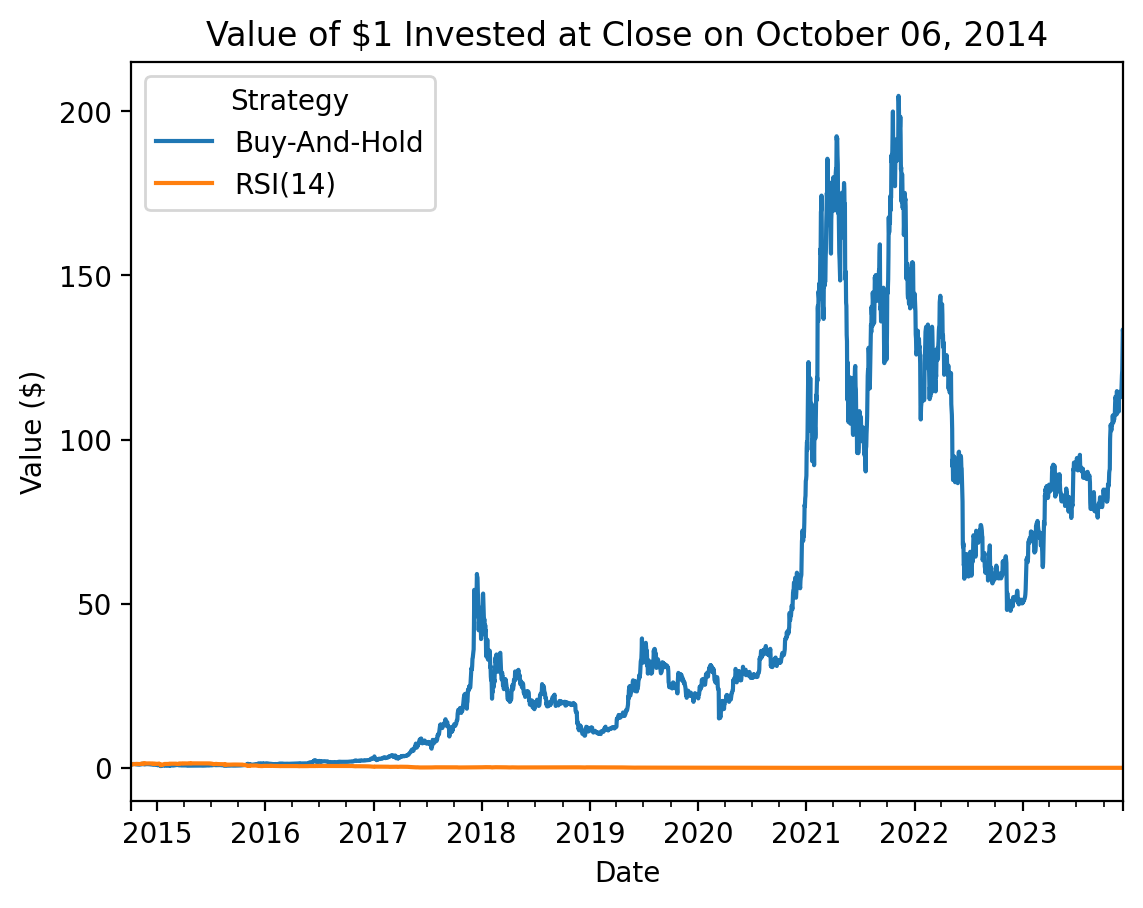

In [28]:
_ = btc_rsi[['Return', 'Strategy']].dropna()

(
    _
    .add(1)
    .cumprod()
    .rename_axis(columns='Strategy')
    .rename(columns={'Return': 'Buy-And-Hold', 'Strategy': 'RSI(14)'})
    .plot()
)
plt.ylabel('Value ($)')
plt.title(f'Value of $1 Invested at Close on {_.index[0] - pd.offsets.Day(1):%B %d, %Y}')
plt.show()

We can compare all three!
Shorting Bitcoin has been dangerous, as the poor returns on RSI(14) show!

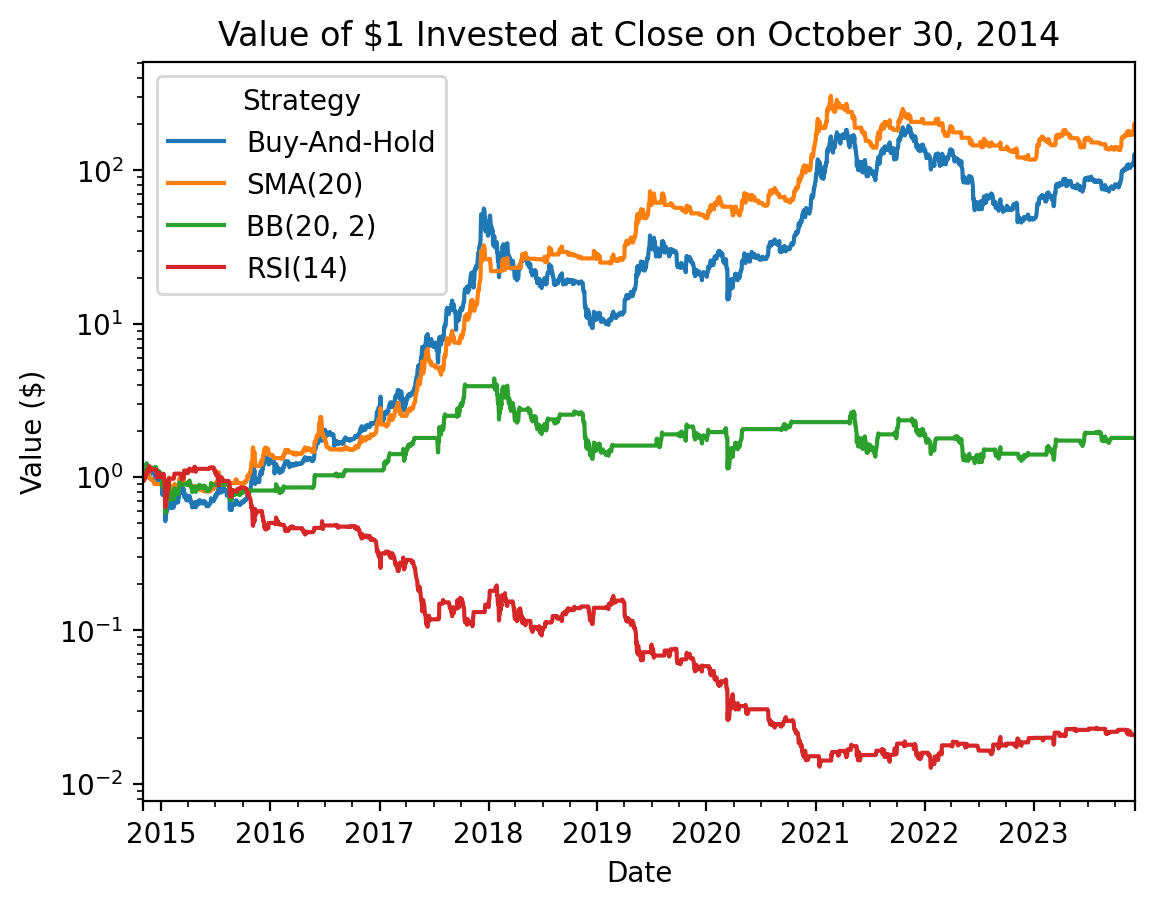

In [29]:
_ = (
    btc_sma[['Return', 'Strategy']]
    .join(
        btc_bb[['Strategy']].add_suffix('_BB'), 
    )
    .join(
        btc_rsi[['Strategy']].add_suffix('_RSI'), 
    )
    .dropna()
)


(
    _
    .add(1)
    .cumprod()
    .rename_axis(columns='Strategy')
    .rename(columns=
            {
                'Return': 'Buy-And-Hold', 
                'Strategy': 'SMA(20)',
                'Strategy_BB': 'BB(20, 2)',
                'Strategy_RSI': 'RSI(14)',
            }
           )
    .plot()
)
plt.semilogy()
plt.ylabel('Value ($)')
plt.title(f'Value of $1 Invested at Close on {_.index[0] - pd.offsets.Day(1):%B %d, %Y}')
plt.show()